In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Helper Methods

In [2]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import seaborn as sns
sns.set()

def corrPlot(df):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    corr = df.corr()
    sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

def getReport(predictions, flag):
    if flag == 'test':
        theDf = target_test
    elif flag == 'val':
        theDf = target_val
    print("Balanced_Accuracy:", balanced_accuracy_score(theDf, predictions))
    print(classification_report(theDf, predictions))
    
def plotROC(model, flag):
    if flag == 'test':
        features = features_test
        target = target_test
    elif flag == 'val':
        features = features_val
        target = target_val
        
    probabilities = model.predict_proba(features)
    preds = probabilities[:,1]
    fpr, tpr, threshold = roc_curve(target, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.xticks([])
    plt.yticks([])
        
    return plt

### Reading in Data

In [16]:
features = pd.read_csv('../datFiles/features.csv', index_col = 0)
target = pd.read_csv('../datFiles/target.csv', index_col = 0, header = None, squeeze = True)

In [17]:
#corrPlot(features)
#savefig('../images/corrPlot.png')

###  Data Manipulation

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

#features = features.values
#features = Normalizer().fit_transform(features)
features = StandardScaler().fit_transform(features)


/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [19]:
from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, random_state=0, )
features_train, features_val, target_train, target_val = train_test_split(features_train, target_train, test_size = 0.2, random_state = 0)

### Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


logit = LogisticRegression(solver='liblinear', max_iter=500)

# best_logit = LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
#           intercept_scaling=0.0001, max_iter=500, multi_class='warn',
#           n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
#           tol=0.0001, verbose=0, warm_start=False)

penalties = ['l1', 'l2']
#tols = [1e-2, 1e-3, 1e-4]
tols = [0.0001]
costs = [0.001, 0.01, 0.1, 1, 5, 10]
intercepts = [0.0001, 0.001, 0.1, 1]
fit_intercepts = [True, False]
classWeights = [None, 'balanced']

params_logit = {'C': costs, 'penalty': penalties, 'tol': tols, 
                'fit_intercept': fit_intercepts, 'class_weight': classWeights, 
                'intercept_scaling': intercepts}


gs_logit = GridSearchCV(logit, params_logit, cv=10)

gs_logit.fit(features_train, target_train)

best_logit = gs_logit.best_estimator_

/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [27]:
best_logit

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=0.0001, max_iter=500, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Balanced_Accuracy: 0.7257905138339921
              precision    recall  f1-score   support

         0.0       0.80      0.89      0.84        88
         1.0       0.72      0.57      0.63        46

   micro avg       0.78      0.78      0.78       134
   macro avg       0.76      0.73      0.74       134
weighted avg       0.77      0.78      0.77       134



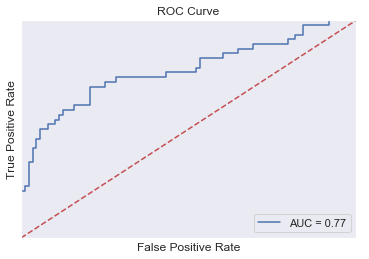

In [26]:
predictions = best_logit.predict(features_val)
getReport(predictions, 'val')
plotROC(best_logit, 'val')
savefig('../images/logit/reg_val_standard.png')

### LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

lda = LinearDiscriminantAnalysis()

std_best_lda = LinearDiscriminantAnalysis(n_components=0, priors=None, shrinkage='auto',
              solver='lsqr', store_covariance=False, tol=0.001)

solvers = ['lsqr']
shrinkages = [None, 'auto']
tols = [1e-3, 1e-4, 1e-5]
components = [0,1]

params_lda = {'solver': solvers,'shrinkage': shrinkages, 'tol': tols, 'n_components':components}

gs_lda = GridSearchCV(lda, params_lda, cv=10)
gs_lda.fit(features_train, target_train)

In [ ]:
gs_lda.best_estimator_

In [ ]:
predictions = gs_lda.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_lda, 'val')
savefig('../images/lda/reg_val.png')

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

std_best_knn = KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')


knn = KNeighborsClassifier()

neighbors = [1,3,5,7,9]
weights = ['uniform', 'distance']
algo = ['ball_tree', 'kd_tree', 'brute']

params_knn = {'n_neighbors': neighbors, 'weights': weights, 'algorithm': algo}
gs_knn = GridSearchCV(knn, params_knn, cv=10)

gs_knn.fit(features_train, target_train)

In [ ]:
gs_knn.best_estimator_

In [ ]:
predictions = gs_knn.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_knn, 'val')
savefig('../images/knn/reg_val.png')

### RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

std_best_rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

rf = RandomForestClassifier(random_state=0)

num_trees = [10, 15, 20, 25, 30, 40, 50]
criterion = ['gini']
max_depth = [10, 20, 30]
min_samples_leaf = [1,2,3,4]
min_samples_split = [1,2,3,4]

params_rf = {'n_estimators': num_trees, 'criterion': criterion, 'max_depth': max_depth}
gs_rf = GridSearchCV(rf, params_rf, cv=10)

gs_rf.fit(features_train, target_train)
gs_rf.best_estimator_

In [ ]:
predictions = gs_rf.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_rf, 'val')
savefig('../images/rf/reg_val.png')

### NN

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

std_best_nn = MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=50, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

nn = MLPClassifier(activation='logistic')

hidden_layer_sizes = [50, 75, 100, 125, 150]
solver = ['lbfgs']
alpha = [1e-3, 1e-4, 1e-5]
tol = [1e-3, 1e-4, 1e-5]



params_nn = {'hidden_layer_sizes': hidden_layer_sizes, 'solver': solver, 'tol': tol}
gs_nn = GridSearchCV(nn, params_nn, cv=10)

gs_nn.fit(features_train, target_train)

In [ ]:
gs_nn.best_estimator_

In [ ]:
predictions = gs_nn.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_nn, 'val')
savefig('../images/nn/reg_val_nn.png')

### SVC

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

std_best_svc = SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


svm = SVC(kernel = 'linear', probability=True)

costs = [0.001, 0.01, 0.1, 1, 5, 10, 100]
gammas = [0.005,.015, 0.01,0.02,0.03,0.04,0.05]
params_svm = {'C': costs, 'gamma' : gammas}

gs_svm = GridSearchCV(svm, params_svm, cv=10)

gs_svm.fit(features_train, target_train)

/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 5, 10, 100], 'gamma': [0.005, 0.015, 0.01, 0.02, 0.03, 0.04, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Balanced_Accuracy: 0.6721837944664031
              precision    recall  f1-score   support

         0.0       0.80      0.67      0.73        88
         1.0       0.52      0.67      0.58        46

   micro avg       0.67      0.67      0.67       134
   macro avg       0.66      0.67      0.66       134
weighted avg       0.70      0.67      0.68       134



<module 'matplotlib.pyplot' from '/Users/hhuang85/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

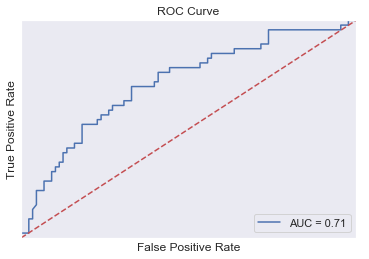

In [8]:
predictions = gs_svm.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_svm, 'val')
#savefig('../images/svc/reg_val_svc_normalized.png')

### QDA REMOVE COLLINEAR VARIABLES

In [20]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

qda = QuadraticDiscriminantAnalysis()

tols = [1e-3, 1e-4, 1e-5]
params_qda = {'tol': tols}

gs_qda = GridSearchCV(qda, params_qda, cv=10)

gs_qda.fit(features_train, target_train)
predictions = gs_qda.predict(features_test)

/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.

/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.

Balanced_Accuracy: 0.6086956521739131
              precision    recall  f1-score   support

         0.0       0.71      1.00      0.83        88
         1.0       1.00      0.22      0.36        46

   micro avg       0.73      0.73      0.73       134
   macro avg       0.85      0.61      0.59       134
weighted avg       0.81      0.73      0.67       134



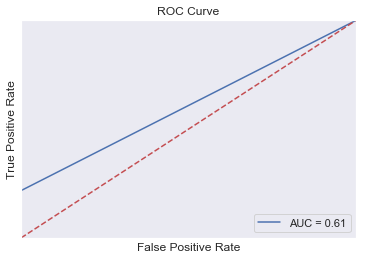

In [21]:
predictions = gs_qda.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_qda, 'val')
savefig('../images/qda/reg_val.png')